# Topic Modelling using LDA on Quora Question Pairs dataset from Kaggle



In [65]:
# Importing the dataset using Kaggle API
import os
os.getcwd()
os.environ['KAGGLE_USERNAME'] = "krithi011" # username from the json file
os.environ['KAGGLE_KEY'] = "1042ec1e291b1d23245e7abb47d4490f" # key from the json file
!kaggle competitions download -c quora-question-pairs 

test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
# Installing packages
!pip install pyLDAvis
!sudo apt install openjdk-8-jdk
!sudo update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!pip install language-check
!pip install pyspellchecker
!python -m spacy download en_core_web_md
!pip install tmtoolkit


In [0]:
# Importing essential Libraries
import spacy #load spacy
import en_core_web_sm
import re # for string manipulation
import unicodedata # For text cleaning 
'''from word2number import w2n
from textblob import TextBlob''' 
from spellchecker import SpellChecker 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
# Plotting tools
import pyLDAvis.gensim

# Data Exploration

In [68]:
train_df = pd.read_csv('train.csv.zip')

train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [69]:
print('Number of training observations', train_df.shape[0])
train_df.info()

Number of training observations 404290
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


## Q1. How many duplicate questions ? And, what percentage of the questions are duplicates?

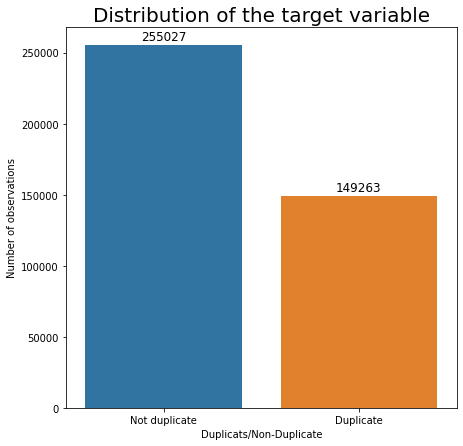

In [70]:
plt.figure(figsize=(7,7))
plot = sns.countplot(train_df['is_duplicate'])
plot.set_xticklabels(['Not duplicate', 'Duplicate'])
for p in plot.patches:
    height = p.get_height()
    width = p.get_x()+p.get_width()/2
    plot.annotate(height, (width,height), xytext = (0, 5), textcoords = "offset points", ha = 'center', fontsize=12)

plt.xlabel('Duplicats/Non-Duplicate')
plt.ylabel('Number of observations')
plt.title('Distribution of the target variable', fontsize = 20);

In [71]:
non_dup = train_df['is_duplicate'].value_counts()[0]
dup = train_df['is_duplicate'].value_counts()[1]

print('Percentage of Duplicate questions in the training data = ', round(dup*100/train_df.shape[0],2))
print('Percentage of Non-duplicate questions in the training data = ', round(non_dup*100/train_df.shape[0],2))

Percentage of Duplicate questions in the training data =  36.92
Percentage of Non-duplicate questions in the training data =  63.08


## Q2. Number of Unique Questions in the dataset

In [72]:
total_qns = train_df['qid1'].append(train_df['qid2'])

print('Total number of unique questions: ', total_qns.nunique())

Total number of unique questions:  537933


## Q3. How many questions appear repeatedly and how often?

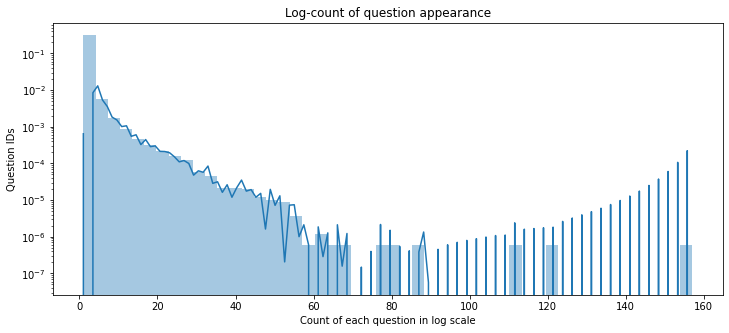

In [73]:
repeat_qns = sum(total_qns.value_counts() > 1)

plt.figure(figsize = (12,5))
sns.distplot(total_qns.value_counts())
plt.yscale('log')
plt.title('Log-count of question appearance')
plt.xlabel('Count of each question in log scale')
plt.ylabel('Question IDs');


## Text Preprocessing

### Missing Values Diagnosis

In [74]:
train_df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

One missing value in **question1** and 2 missing values in **question2**. We fill up NaNs with blank.

In [0]:
train_df = train_df.fillna('')

# Q4. What is the distribution of the length of questions?

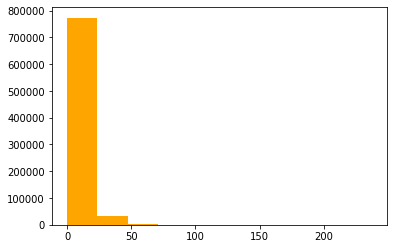

In [76]:
all_questions = train_df['question1'].append(train_df['question2']).to_list()

line_lengths = [len(text.split()) for text in all_questions]

h = plt.hist(line_lengths, bins = 50)

tokens = [item.split() for item in all_questions]
total_tokens_per_line = [len(item.split()) for item in all_questions]
h = plt.hist(total_tokens_per_line, color='orange')

### Data Cleaning and pre-processing

Essential Packages for text processing such as spacy and spell Checker have already be imported earlier. 

The definitions of the different cleaning functions are given below.

In [0]:

''' Function to check and correct Spellings '''
def spell_correction(text):
  spell = SpellChecker()
  words = spell.split_words(text)
  return ' '.join([spell.correction(word) for word in words])


''' The main cleaning function '''
def string_cleaning(qn):
   # Replace special chars in text
    
    qn = re.sub("’", "'", qn) # special single quote
    qn = re.sub("`", "'", qn) # special single quote
    qn = re.sub("“", '"', qn) # special double quote
    qn = re.sub("？", "?", qn) 
    qn = re.sub("…", " ", qn) 

    #Spell check
    qn = spell_correction(qn)

    #Remove all punctuation
    pattern = r'[^a-zA-z\s]'
    qn = re.sub(pattern, '', qn)

    # Clean shorthands

    qn = re.sub("e\.g\.", " eg ", qn, flags=re.IGNORECASE)
    qn = re.sub("b\.g\.", " bg ", qn, flags=re.IGNORECASE)
    qn = re.sub(r"(\W|^)([0-9]+)[kK](\W|$)", r"\1\g<2>000\3", qn) 
    qn = re.sub("e-mail", " email ", qn, flags=re.IGNORECASE)
    qn = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", qn, flags=re.IGNORECASE)
    qn = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", qn, flags=re.IGNORECASE)
    qn = re.sub("\(s\)", " ", qn, flags=re.IGNORECASE)
    qn = re.sub("[c-fC-F]\:\/", " disk ", qn)
    
    # replace the float numbers with a random number, it will be parsed as number afterward, and also been replaced with word "number"
    
    qn = re.sub('[0-9]+\.[0-9]+', " 99 ", qn)
     
    # add padding to punctuations and special chars
    
    qn = re.sub('\$', " dollar ", qn)
    qn = re.sub('\%', " percent ", qn)
    qn = re.sub('\&', " and ", qn)

    return qn


In [0]:
nlp = en_core_web_sm.load()
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
spacy_stopwords.add('di')
spacy_stopwords.add('d')
exception = {'no','like','not'}
spacy_stopwords = set([word for word in spacy_stopwords if word not in exception])


def preprocess(qn):
    # String operations
    
    qn = qn.lower()
    qn = string_cleaning(qn)

    #Tokenize text

    tokens = nlp(qn)

    #Lemmatization
    lemma_list = []
    for token in tokens:
        flag = True
        hold = token.text.strip()
        if token.is_stop and token.pos_ != 'NUM': 
            flag = False

        elif token.lemma_ != "-PRON-" and token.lemma_.isalpha() and flag == True:
            hold = token.lemma_

        if flag == True and hold != '' and len(hold) > 2:
            lemma_list.append(hold)
        #token_list

    return list(set(' '.join(lemma_list).split()))  


Creating a copy of the original dataframe and continuing with text preprocessing.

Due to computational constraints on the local system and non-availability of GPU at the time of execution, the topic modelling has been applied on a subset of data (2000 observations). The notion of this experiment is to understand and apply acquired knowledge and re-create a prototype of LDA application for topic modelling.

In [0]:
train_cpy = train_df[train_df['is_duplicate'] == 0 ].loc[0:2000, ['question1', 'question2']]


In [0]:
#
train_cpy['question1'] = train_cpy['question1'].apply(lambda x: preprocess(str(x))) 
train_cpy['question2'] = train_cpy['question2'].apply(lambda x: preprocess(str(x)))

In [81]:
train_cpy.head()

,question1,question2
0,"[step, share, market, invest, guide, india]","[step, share, market, invest, guide]"
1,"[diamond, koh, noor, story, kohinoor]","[diamond, government, koh, indian, steal, happ..."
2,"[connection, increase, vpn, speed, internet]","[increase, speed, hack, internet, dns]"
3,"[solve, lonely, mentally]","[math, find, remainder, divide]"
4,"[salt, carbon, water, methane, one, sugar, oxi...","[salt, water, survive, fish]"


# Topic Modelling

Create a dataset with question1 and question2 appended from the train data.

In [0]:
s1 = train_cpy["question1"]
s2 = train_cpy["question2"]
data = s1.append(s2)

# Topic clustering using Gensim

## Step 1: Creating the dictionary from the corpus

In [83]:
dictionary = gensim.corpora.Dictionary(data)


2020-04-29 21:09:47,871 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-04-29 21:09:47,903 : INFO : built Dictionary(3927 unique tokens: ['guide', 'india', 'invest', 'market', 'share']...) from 2518 documents (total 12845 corpus positions)


Next we filter out words that are either too frequent in the overall corpus of questions (i.e. occuring more than 50%) or too rare (i.e. occuring in less than 50 questions)

In [84]:
dictionary.filter_extremes(no_below=2, no_above=0.5, keep_n=10000)

2020-04-29 21:09:47,917 : INFO : discarding 1893 tokens: [('connection', 1), ('vpn', 1), ('dissolve', 1), ('methane', 1), ('oxide', 1), ('iago', 1), ('charter', 1), ('baptism', 1), ('prestel', 1), ('separation', 1)]...
2020-04-29 21:09:47,918 : INFO : keeping 2034 tokens which were in no less than 2 and no more than 1259 (=50.0%) documents
2020-04-29 21:09:47,922 : INFO : resulting dictionary: Dictionary(2034 unique tokens: ['guide', 'india', 'invest', 'market', 'share']...)


## Step 2: Creating Bag-of-Words from the Tokens

In [85]:
bow_corpus = [dictionary.doc2bow(doc) for doc in data]
'''
bow_doc_100 = bow_corpus[100]
for i in range(len(bow_doc_100)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_100[i][0], 
                                               dictionary[bow_doc_100[i][0]], 
bow_doc_100[i][1]))'''

'\nbow_doc_100 = bow_corpus[100]\nfor i in range(len(bow_doc_100)):\n    print("Word {} ("{}") appears {} time.".format(bow_doc_100[i][0], \n                                               dictionary[bow_doc_100[i][0]], \nbow_doc_100[i][1]))'

## Step 3: Creating the Document-Term Matrix using TF-IDF Vectorizer 

In [86]:
tfidf = models.TfidfModel(bow_corpus)


2020-04-29 21:09:47,952 : INFO : collecting document frequencies
2020-04-29 21:09:47,952 : INFO : PROGRESS: processing document #0
2020-04-29 21:09:47,958 : INFO : calculating IDF weights for 2518 documents and 2033 features (10952 matrix non-zeros)


In [0]:
# If value is high, it means the word has a higher tf-idf weight.
# We want to remove words that have less weight i.e. as low as 0.1
low_value = 0.1
low_value_words = []
for item in bow_corpus:
    low_value_words += [id for id, value in tfidf[item] if value < low_value]
dictionary.filter_tokens(bad_ids=low_value_words)
corpus = [dictionary.doc2bow(doc) for doc in data]

## Step 4: Running the LDA Algorithm from Gensim Package

Key parameters:

1.   Bag of words corpus after filtering words based on TF-IDF score
2.   Dictionary (created from the corpus)
3.   Number of topic (arbitarily chosen as 10) 



In [0]:
lda_model = gensim.models.LdaMulticore(corpus, num_topics=10, id2word=dictionary, passes=20, workers=4)

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [89]:
# each element of the list is a tuple 
# containing the topic and word / probability list
topics = lda_model.show_topics(num_words = 10, formatted = True)
topics

[(0,
  '0.025*"mean" + 0.020*"quota" + 0.020*"like" + 0.020*"don" + 0.016*"india" + 0.012*"feel" + 0.012*"question" + 0.010*"movie" + 0.009*"computer" + 0.008*"people"'),
 (1,
  '0.023*"think" + 0.023*"trump" + 0.018*"donald" + 0.015*"people" + 0.011*"world" + 0.009*"india" + 0.009*"com" + 0.009*"company" + 0.008*"election" + 0.008*"way"'),
 (2,
  '0.022*"good" + 0.012*"buy" + 0.012*"start" + 0.012*"time" + 0.012*"thing" + 0.011*"place" + 0.009*"day" + 0.009*"goole" + 0.008*"india" + 0.007*"laptop"'),
 (3,
  '0.027*"difference" + 0.012*"lose" + 0.011*"cause" + 0.010*"use" + 0.010*"weight" + 0.010*"build" + 0.010*"need" + 0.009*"write" + 0.009*"phone" + 0.008*"eat"'),
 (4,
  '0.079*"good" + 0.016*"way" + 0.015*"learn" + 0.010*"india" + 0.010*"online" + 0.009*"language" + 0.008*"download" + 0.008*"cost" + 0.008*"company" + 0.008*"study"'),
 (5,
  '0.019*"like" + 0.015*"one" + 0.014*"new" + 0.011*"man" + 0.011*"find" + 0.008*"use" + 0.008*"good" + 0.008*"different" + 0.007*"come" + 0.007*

In [0]:
def find_coherence(corpus, dictionary, topic):
  lda_model = gensim.models.LdaMulticore(num_topics= topic,
                      corpus=corpus,
                      id2word=dictionary,
                      passes=20,
                      eval_every=None,
                      workers = 4)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=data, dictionary=dictionary, coherence='c_v')

  coherence_lda = coherence_model_lda.get_coherence()
  return coherence_lda



# Range of topics
min_topics = 5
max_topics = 30
step_size = 2
topics_range = range(min_topics, max_topics, step_size)

results = { 'Topics' : [],
           'Coherence' : []}

for k in topics_range:
  cv = find_coherence(corpus, dictionary, topic = k)
  results['Topics'].append(k)
  results['Coherence'].append(cv)

results_df = pd.DataFrame(results)


    Topics  Coherence
0        5   0.592744
1        7   0.556024
2        9   0.575161
3       11   0.591673
4       13   0.581587
5       15   0.572096
6       17   0.565384
7       19   0.563418
8       21   0.576238
9       23   0.599759
10      25   0.599805
11      27   0.581340
12      29   0.596536


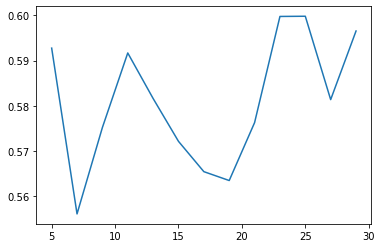

In [91]:
print(results_df)
plt.plot('Topics', 'Coherence', data = results_df);

Based on the Cross validation done above on number of topics, we observe that the coherence score attains it's first peak at num_topics = 13. 

In [0]:
lda_model = gensim.models.LdaMulticore(num_topics= 13,
                      corpus=corpus,
                      id2word=dictionary,
                      passes=20,
                      eval_every=None,
                      workers = 4)



In [0]:
'''Excellent resource

https://tmtoolkit.readthedocs.io/en/latest/topic_modeling.html#Visualizing-topic-models

https://datascience.blog.wzb.eu/2017/11/09/topic-modeling-evaluation-in-python-with-tmtoolkit/

https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28'''

# Visualization


In [94]:
lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)